In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn') 

In [2]:
!pip install ffmpeg

In [3]:
from matplotlib.animation import FuncAnimation

In [4]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [5]:
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rcParams['font.size'] = 13

### Define vehicle dynamics:


In [6]:
n_x = 4
n_u = 2
def unicycle_continuous_dynamics(x, u):
    # x = [x position, y position, heading, forward velocity] 
    # u = [omega, forward acceleration]
    #m = sym if x.dtype == object else np # Check type for autodiff
    x_pos = x[3]*np.cos(x[2])
    y_pos = x[3]*np.sin(x[2])
    heading_rate = u[0]
    v_dot = u[1]
    x_d = np.array([
        x_pos,
        y_pos,
        heading_rate,
        v_dot    
    ])
    return x_d

In [7]:
def discrete_dynamics(x, u):
    dt = 0.05
    #Euler integrator below and return the next state
    x = x + dt*unicycle_continuous_dynamics(x,u)
    x_next = x
    return x_next

In [8]:
def discrete_dynamics_multiple(x,u,x_dim,u_dim):
    
    x_new = []
    x_split = np.split(x,np.cumsum(x_dim[:-1]))
    u_split = np.split(u,np.cumsum(u_dim[:-1]))
    for xi,ui in zip(x_split,u_split):
        x_next = discrete_dynamics(xi,ui)
        x_new.append(x_next)
    return np.asarray(x_new).flatten()

### Rollout 


In [9]:
def rollout(x0, u_trj): #rolling out the state trajectory based on the euqations of motion (discretized)

    x_trj = np.zeros((u_trj.shape[0]+1, x0.shape[0]))

    x_trj[0,:] = x0
    
    for i in range(0,x_trj.shape[0]-1): 
        x_trj[i+1,:] = discrete_dynamics_multiple(x_trj[i,:],u_trj[i,:],(4,4,4),(2,2,2))
    return x_trj

# N = 15
# x0 = np.array([3.5,3.5,0.1,1,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
#                -3.5,3.5,0.2,-0.5,   
#                3,3.5,0.1,0.2]) 
# u_trj = np.zeros((N-1, 3*n_u))
# x_trj = rollout(x0, u_trj)

### Designate a constant reference trajectory for the 3-agent system:

In [10]:
# x0 = np.array([0.5, 1.5, 0.05, 1,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
#                3.5, 1.5, 0.2 ,-0.5,  
#                2.0, 1.1, 0.15 , 0.2 ]) 

In [11]:
# use this cell to mimick the 2 scenarios mentioned in the paper 
#Potential iLQR: A Potential-Minimizing Controller for Planning Multi-Agent Interactive Trajectories. 10.15607/RSS.2021.XVII.084.

# Q = np.eye(12)*100;
# R = np.eye(6);


#x_T = x_trj[-1,:]
# x_ref = np.array([2.5, 1.5, 0 , 0,     #1st row for agent1, 2nd row for agent2, 3rd row for agent3
#                0.5, 1.5, 0 , 0 ,    
#                1.8, 2.2 , 0.0, 0.0])
# x_ref_T = x_ref
# u_ref = np.zeros(6,)
#agent 1 and agent 2 exchange, agent 3 -> (between 1 and 2)

### Define cost functions:

In [12]:
def cost_trj(x,u): #x-> state vector, u-> input vectora
    #m = sym if x.dtype == object else np
    
    
    
    cost = (x-x_ref).T @ Q @(x-x_ref) +(u).T @ R @ (u)

    return cost #trajectory cost for an agent with index i

In [13]:
def cost_trj_Final(x_T):
   # m = sym if x.dtype == object else np
    Q = np.eye(12)*1600
    
    terminal_cost = (x_T-x_ref_T).T @ Q @ (x_T-x_ref_T)

    return terminal_cost #final trajectory cost for an agent with index i

In [14]:
#eps = 1e-6
def cost_avoidance(x): # `hard coded` for 3 agents! so x must have shape (12,) and u has shape (6,)
   

    threshold = 0.5 #meters 

    pos_x1_coor = [x[0], x[1]]
    pos_x2_coor = [x[4], x[5]]
    pos_x3_coor = [x[8] , x[9]]
    
    #Euclidean distance between agent i and j
    d_12 = np.sqrt((pos_x1_coor[0]-pos_x2_coor[0])**2+(pos_x1_coor[1]-pos_x2_coor[1])**2)
    d_13 = np.sqrt((pos_x1_coor[0]-pos_x3_coor[0])**2+(pos_x3_coor[1]-pos_x3_coor[1])**2)
    d_23 = np.sqrt((pos_x2_coor[0]-pos_x3_coor[0])**2+(pos_x2_coor[1]-pos_x3_coor[1])**2)
    
    d_12_cost = 0
    d_13_cost = 0
    d_23_cost = 0 

    if d_12 < threshold:
        d_12_cost = (d_12-threshold)**2
   
    elif d_23 < threshold:
        d_23_cost = (d_23-threshold)**2
        
    elif d_13 < threshold:

        d_13_cost = (d_13-threshold)**2 

    return 750*(d_12_cost+d_13_cost+d_23_cost)

In [15]:
def cost_stage(x, u):
    
    c_avoid = cost_avoidance(x)
    c_trj = cost_trj(x,u)
    
    return c_avoid + c_trj
    

In [16]:
def cost_sum(x_trj, u_trj):

    total = 0.0
    # TODO: Sum up all costs
    for i in range(0,x_trj.shape[0]-1): #(0,1,2,3,....)
        total = total + cost_stage(x_trj[i,:],u_trj[i,:]) 

    total = total + cost_trj_Final(x_trj[-1,:])

    return total

In [17]:
# cost_sum(x_trj,u_trj)

### Bellman recursion (ref:http://underactuated.mit.edu/trajopt.html#section8)


Now that we are warmed up, let's derive the actual algorithm. We start with the Bellman equation known from lecture defining optimality in a recursively backwards in time.
\begin{align*} V(\mathbf{x}[n]) = & \min_{\mathbf{u}[n]} \quad \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\
\end{align*}

You may have noticed that we neglected a couple of constraints of the original problem formulation. The fully equivalent formulation is 
\begin{align*} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1]
\\ \text{subject to} \quad 
& Q(\mathbf{x}[n], \mathbf{u}[n]) = \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\
& V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N]) \\
& \mathbf{x}[n+1] = {\bf      f}(\mathbf{x}[n], \mathbf{u}[n]), \quad \\ 
& \mathbf{x}[0] = \mathbf{x}_0.
\end{align*}
The definition of a Q-function will become handy during the derivation of the algorithm.

The key idea of iLQR is simple: Approximate the dynamics linearly and the costs quadratically around a nominal trajectory. We will expand all terms of the Q-function accordingly and optimize the resulting quadratic equation for an optimal linear control law in closed form. We will see that by applying the Bellman equation recursively backwards in time, the value function remains a quadratic.
The linear and quadratic approximations are computed around the nominal state $\bf \bar{x} = \bf x - \delta \bf x$ and the nominal control $\bf \bar{u} = \bf u - \delta \bf u$. After applying the Bellman equation backwards in time from time $N$ to $0$ (the backward pass), we will update the nominal controls $\bf \bar{u}$ and states $\bf \bar{x}$ by applying the computed linear feedback law from the backward pass and rolling out the dynamics from the initial state $\bf x_0$ to the final horizon $N$. Iterating between backwards and forwards pass optimizes the control problem.

### Q-function Expansion

Let's start by expanding all terms in the Q-function of the Bellman equation. The quadaratic cost function is
\begin{align*} 
\ell(\mathbf{x}[n], \mathbf{u}[n]) \approx \ell_n 
+ \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\  
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix},
\end{align*}
and the dynamics function is
\begin{align*} x[n+1]=
\mathbf{f}(\mathbf{x}[n], \mathbf{u}[n]) \approx \mathbf{f}_n
+ \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}
Here, $\ell = \ell(\bar{\mathbf{x}}, \bar{\mathbf{u}})$ and $\mathbf{f} = \mathbf{f}(\bar{\mathbf{x}}, \bar{\mathbf{u}})$. $\ell_\mathbf{x}, \ell_\mathbf{u}, \mathbf{f}_\mathbf{x}, \mathbf{f}_\mathbf{u}$ are the gradients and Jacobians evaluated at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. $\ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}$ are the Hessians at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. The expansion of the final cost follows analogously.
The code to evaluate all the derivative terms is:

In [18]:
from scipy.optimize import approx_fprime

In [19]:
# l_x = np.zeros((n_x))
# l_u = np.zeros((n_u))
# l_xx = np.zeros((n_x, n_x))
# l_uu = np.zeros((n_u, n_u))
# l_ux = np.zeros((n_u, n_x))

In [20]:
# the following x and u vectors will be overwritten later on
# x = np.array([5,10 , 0.1, 0,     
#                2.5, -3, 0, 0,
#                3,2,0.3,0.2])
# u = np.array([1,1,
#             -1,0.9,
#             1,0.5])

### Defining derivatives of cost_stage(x,u) : `l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u`

In [21]:
n_x

4

In [22]:
n_u

2

In [23]:
_jac_eps = np.sqrt(np.finfo(float).eps)
_hess_eps = np.sqrt(_jac_eps)


def l_x(x,u):
  
    return approx_fprime(x, lambda x: cost_stage(x,u), _jac_eps) #1e-8

def l_u(x,u):
    
    return approx_fprime(u, lambda u: cost_stage(x,u), _jac_eps) #1e-8

def l_xx(x,u):
    
    return np.vstack([
            approx_fprime(x, lambda x: l_x(x, u)[i], _hess_eps) for i in range(3*n_x)
        ])   

# l_xx = np.vstack([
#             approx_fprime(x, lambda x: l_x(x, u)[i], 1e-3) for i in range(3*n_x)
#         ])         

# l_uu = np.vstack([
#           approx_fprime(u, lambda u: l_u(x, u)[i], 1e-3) for i in range(3*n_u)
#       ])
def l_uu(x,u):
    
    return np.vstack([
           approx_fprime(u, lambda u: l_u(x, u)[i], _hess_eps) for i in range(3*n_u)
          ])


# l_ux = np.vstack([
#             approx_fprime(x, lambda x: l_u(x, u)[i], 1e-3) for i in range(3*n_u)
#         ])


def l_ux(x,u):
    
    return np.vstack([
             approx_fprime(x, lambda x: l_u(x, u)[i], _hess_eps) for i in range(3*n_u)
         ])

In [24]:

def f(x,u):
    x_dim = (4,4,4)
    u_dim = (2,2,2)
    return discrete_dynamics_multiple(x,u,x_dim,u_dim)

def f_x(x,u):

    return np.vstack([
             approx_fprime(x, lambda x: f(x,u)[i], _jac_eps) for i in range(3*n_x)
         ]) 

# f_x = np.vstack([
#             approx_fprime(x, lambda x: f(x,u)[i], 1e-3) for i in range(3*n_x)
#         ])   

# f_u = np.vstack([
#             approx_fprime(u, lambda u: f(x,u)[i], 1e-3) for i in range(3*n_x) #f_u should be (12,6)
#         ])  




def f_u(x,u):
    return np.vstack([
            approx_fprime(u, lambda u: f(x,u)[i], _jac_eps) for i in range(3*n_x) #f_u should be (12,6)
        ])  

In [25]:
def l_final_x(x_T):
    
    
    return np.eye(x_T.shape[0])*1600@(x_T-x_ref_T)

#l_final_xx = np.vstack([
#            approx_fprime(x, lambda x: l_final_x(x_T)[i], 1e-6) for i in range(3*n_x) #1e-8
#        ])    

def l_final_xx(x_T):
    
    
    
    return np.eye(x_T.shape[0])*1600



# l_final_xx = np.eye(x_T.shape[0])*1600

Expanding the second term of the Q-function of the Bellman equation, i.e. the value function at the next state $\mathbf{x}[n+1]$, to second order yields \begin{align*} 
V(\mathbf{x}[n+1]) \approx V_{n+1} + 
V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T 
V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1],
\end{align*}
where $\delta \mathbf{x}[n+1]$ is given by
\begin{align*} 
\delta \mathbf{x}[n+1] 
& = \mathbf{x}[n+1] - \bar{\mathbf{x}}[n+1] \\
& = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \bar{\mathbf{x}}[n+1] \\
& = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \mathbf{f}(\bar{\mathbf{x}}[n], \bar{\mathbf{u}}[n]) \\
& = \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}   \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}

We have now expanded all terms of the Bellman equation and can regroup them in the form of
\begin{align*} 
Q(\mathbf{x}[n], \mathbf{u}[n]) & 
\approx \ell_n 
+ \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\  
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}, \\
 & \quad + V_{n+1} + 
V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T 
V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1], \\
& = Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.
\end{align*}
Find $Q_{\mathbf{x},n}$, $Q_{\mathbf{u},n}$, $Q_{\mathbf{xx},n}$, $Q_{\mathbf{ux},n}$, $Q_{\mathbf{uu},n}$ in terms of $\ell$ and $\textbf{f}$ and their expansions by collecitng coefficients in $(\cdot)\delta \mathbf{x}[n]$, $(\cdot)\delta \mathbf{u}[n]$, $1/2 \delta \mathbf{x}[n]^T (\cdot) \delta \mathbf{x}[n]$, and similar. Write your results in the corresponding function below.

In [26]:
def Q_terms(V_x, V_xx , x, u):
    # TODO: Define the Q-terms here
    #l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivatives.stage(x,u);
    
    # Q_x = np.zeros(l_x(x,u).shape) #(12,)
    # Q_u = np.zeros(l_u(x,u).shape) #(6,)
    # Q_xx = np.zeros(l_xx(x,u).shape)    #(12, 12)
    # Q_ux = np.zeros(l_ux(x,u).shape)    #(6, 12)
    # Q_uu = np.zeros(l_uu(x,u).shape)    #(6, 6)

    #l_x(x,u)->(12,)
    #f_x -> (12, 12)
    #V_x -> (12,)
    
    #l_u(x,u) ->(6,)
    #f_u_ -> (12,6)
    # x_dim = (4,4,4)
    # u_dim = (2,2,2)


    Q_x = l_x(x,u)+f_x(x,u).T.dot(V_x);
    
    
    Q_u = l_u(x,u)+f_u(x,u).T.dot(V_x);
    
    Q_xx = l_xx(x,u) + f_x(x,u).T.dot(V_xx.dot(f_x(x,u)))
    
    Q_ux = l_ux(x,u) +f_u(x,u).T.dot(V_xx.dot(f_x(x,u)))
    Q_uu = l_uu(x,u) + f_u(x,u).T.dot(V_xx.dot(f_u(x,u)))

    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

### Q-function Optimization and Optimal Linear Control Law
Now that we have the Q-function in quadratic form, we can optimize for the optimal control gains in closed form.
The original formulation, i.e. optimizing over $\mathbf{u}[n]$,
\begin{align*} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]),
\end{align*} is equivalent to optimzing over $\delta \mathbf{u}[n]$.

\begin{align*} 
\delta \mathbf{u}[n]^* = {\arg\!\min}_{\delta \mathbf{u}[n]} \quad Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
 = k + K \delta \mathbf{x}[n]
\end{align*} It turns out that the optimal control is linear in $\delta \mathbf{x}[n]$.
Solve the quadratic optimization analytically and derive equations for the feedforward gains $k$ and feedback gains $K$. Implement the function below. Hint: You do not need to compute $Q_\mathbf{uu}^{-1}$ by hand.

In [27]:
def gains(Q_uu, Q_u, Q_ux):
   
    #Q_uu_inv = np.linalg.inv(Q_uu)
    # TOD: Implement the feedforward gain k and feedback gain K.
    # k = np.zeros(Q_u.shape)
    # K = np.zeros(Q_ux.shape)

    # k= -Q_uu_inv.dot(Q_u);
    # K = - Q_uu_inv.dot(Q_ux);
    
    k = np.linalg.solve(Q_uu,-Q_u)
    K = np.linalg.solve(Q_uu,-Q_ux)
    
    
    return k, K

### Value Function Backward Update
We are almost done! We need to derive the backwards update equation for the value function. We simply plugin the optimal control $\delta \mathbf{u}[n]^* = k + K \delta \mathbf{x}[n]$ back into the Q-function which yields the value function
\begin{align*} 
V(\mathbf{x}[n]) \approx V_{n} + 
V_{\mathbf{x},n}^T  \delta \mathbf{x}[n] + \frac{1}{2}\delta \mathbf{x}[n]^T 
V_{\mathbf{xx},n} \delta \mathbf{x}[n] = Q_n 
+ \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix}^T  
\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix} 
+ \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}^T 
\begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  
Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}
 \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}.
\end{align*}
Compare terms in $(\cdot) \delta \mathbf{x}[n]$ and $ 1/2 \delta \mathbf{x}[n]^T (\cdot)  \delta \mathbf{x}[n]$, find $V_{\mathbf{x},n}$, and $V_{\mathbf{xx},n}$ and implement the corresponding function below.

In [28]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
#     V_x = np.zeros(Q_x.shape)
#     V_xx = np.zeros(Q_xx.shape)
    
    
    V_x = Q_x + K.T.dot(Q_uu.dot(k)) + K.T.dot(Q_u) + Q_ux.T.dot(k);
    V_xx = Q_xx  + K.T.dot(Q_uu.dot(K)) + K.T.dot(Q_ux) + Q_ux.T.dot(K) ;
    
    
    
    return V_x, V_xx

### Expected Cost Reduction
We can also estimate by how much we expect to reduce the cost by applying the optimal controls. Simply subtract the previous nominal Q-value ($\delta \mathbf{x}[n] = 0$ and $\delta \mathbf{u}[n]=0$) from the value function.  The result is implemented below and is a useful aid in checking how accurate the quadratic approximation is during convergence of iLQR and adapting stepsize and regularization.

In [29]:
# def expected_cost_reduction(Q_u, Q_uu, k):
#     return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

In [30]:
def expected_cost_reduction(Q_u, Q_uu, k, alpha):
    
    return - alpha*Q_u.T.dot(k) - 0.5  * alpha**2 *   k.T.dot(Q_uu.dot(k))

### Forward Pass
We have now have all the ingredients to implement the forward pass and the backward pass of iLQR. In the forward pass, at each timestep the new updated control $\mathbf{u}' =  \bar{\mathbf{u}} + k + K (x' - \bar{\mathbf{x}})$ is applied and the dynamis propagated based on the updated control. The nominal control and state trajectory $\bar{\mathbf{u}}, \bar{\mathbf{x}}$ with which we computed $k$ and $K$ are then updated and we receive a new set of state and control trajectories.

In [31]:
# def forward_pass(x_trj, u_trj, k_trj, K_trj):
#     alpha = 1
#     x_trj_new = np.zeros(x_trj.shape)
#     x_trj_new[0,:] = x_trj[0,:]
#     u_trj_new = np.zeros(u_trj.shape)
#     # TODO: Implement the forward pass here
# #     for n in range(u_trj.shape[0]):
# #         u_trj_new[n,:] = # Apply feedback law
# #         x_trj_new[n+1,:] = # Apply dynamics
#     for n in range(u_trj.shape[0]):
#         u_trj_new[n,:] =u_trj[n,:]+ k_trj[n,:] + K_trj[n,:].dot((x_trj_new[n,:]-x_trj[n,:])); # Apply feedback law
#         x_trj_new[n+1,:] =discrete_dynamics_multiple(x_trj_new[n,:],u_trj_new[n,:],(4,4,4),(2,2,2));
    
#     return x_trj_new, u_trj_new

In [32]:
def forward_pass(x_trj, u_trj, k_trj, K_trj, expected_cost_redu, total_cost, alpha ):
    #alpha is the gradient descent rate

  
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
#     for n in range(u_trj.shape[0]):
#         u_trj_new[n,:] = # Apply feedback law
#         x_trj_new[n+1,:] = # Apply dynamics

    for n in range(u_trj.shape[0]):
        u_trj_new[n,:] =u_trj[n,:]+ alpha * k_trj[n,:] + K_trj[n,:].dot((x_trj_new[n,:]-x_trj[n,:])); # Apply feedback law
        x_trj_new[n+1,:] =discrete_dynamics_multiple(x_trj_new[n,:],u_trj_new[n,:],(4,4,4),(2,2,2));
    
   
    
    return x_trj_new, u_trj_new

### Backward Pass
The backward pass starts from the terminal boundary condition $V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N])$, such that $V_{\mathbf{x},N} = \ell_{\mathbf{x},f}$ and $V_{\mathbf{xx},N} = \ell_{\mathbf{xx},f}$. In the backwards loop terms for the Q-function at $n$ are computed based on the quadratic value function approximation at $n+1$ and the derivatives and hessians of dynamics and cost functions at $n$. To solve for the gains $k$ and $K$ an inversion of the matrix $Q_\mathbf{uu}$ is necessary. To ensure invertability and to improve conditioning we add a diagonal matrix to $Q_\mathbf{uu}$. This is equivalent to adding a quadratic penalty on the distance of the new control trajectory from the control trajectory of the previous iteration. The result is a smaller stepsize and more conservative convergence properties.

In [33]:
# def backward_pass(x_trj, u_trj, regu):
#     k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
#     K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
#     expected_cost_redu = 0
#     # TODO: Set terminal boundary condition here (V_x, V_xx)

#     #l_final_x= derivs.final(x_trj[-1,:])[0]
#     #l_final_xx= derivs.final(x_trj[-1,:])[1]  

#     V_x = np.zeros((x_trj.shape[1],))
#     V_x = V_x+l_final_x(x_trj[-1,:]);

#     V_xx = np.zeros((x_trj.shape[1],x_trj.shape[1]))
#     V_xx =V_xx+ l_final_xx;
    
#     for n in range(u_trj.shape[0]-1, -1, -1):
#         # TODO: First compute derivatives, then the Q-terms 
#         #l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n,:],u_trj[n,:]);
     
#         Q_x = np.zeros((x_trj.shape[1],))
#         Q_x=Q_x+Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[0];

#         Q_u = np.zeros((u_trj.shape[1],))
#         Q_u=Q_u+Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[1];

#         Q_xx = np.zeros((x_trj.shape[1], x_trj.shape[1])) 
#         Q_xx=Q_xx+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[2];

#         Q_ux = np.zeros((u_trj.shape[1], x_trj.shape[1]))
#         Q_ux=Q_ux+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[3];

#         Q_uu = np.zeros((u_trj.shape[1], u_trj.shape[1]))
#         Q_uu=Q_uu+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[4];
        
#         # We add regularization to ensure that Q_uu is invertible and nicely conditioned
#         Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
#         k, K = gains(Q_uu_regu, Q_u, Q_ux)
#         k_trj[n,:] = k
#         K_trj[n,:,:] = K
#         V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
#         expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
#     return k_trj, K_trj, expected_cost_redu

In [34]:
def backward_pass(x_trj, u_trj, regu, alpha):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)

    #l_final_x= derivs.final(x_trj[-1,:])[0]
    #l_final_xx= derivs.final(x_trj[-1,:])[1]  

    # V_x = np.zeros((x_trj.shape[1],))
    #V_x = V_x+l_final_x(x_trj[-1,:]);
    V_x = l_final_x(x_trj[-1,:])
    
    # V_xx = np.zeros((x_trj.shape[1],x_trj.shape[1]))
    #V_xx =V_xx+ l_final_xx(x_trj[-1,:]);
    V_xx = l_final_xx(x_trj[-1,:])
    
    
    for n in range(u_trj.shape[0]-1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms 
        #l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n,:],u_trj[n,:]);
     
          #Q_x = np.zeros((x_trj.shape[1],))
#         #Q_x=Q_x+Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[0];
#         Q_x[:,] = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[0]
        
#         Q_u = np.zeros((u_trj.shape[1],))
#         #Q_u=Q_u+Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[1];
#         Q_u[:,] = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[1]

#         Q_xx = np.zeros((x_trj.shape[1], x_trj.shape[1])) 
#         #Q_xx=Q_xx+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[2];
#         Q_xx[:,:] = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[2]
        
#         Q_ux = np.zeros((u_trj.shape[1], x_trj.shape[1]))
#         #Q_ux=Q_ux+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[3];
#         Q_ux[:,:] = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[3];
        
#         Q_uu = np.zeros((u_trj.shape[1], u_trj.shape[1]))
#         #Q_uu=Q_uu+ Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[4];
#         Q_uu[:,:] = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])[4];
        
        Q_x,Q_u,Q_xx,Q_ux,Q_uu = Q_terms(V_x, V_xx,x_trj[n+1,:],u_trj[n,:])
        
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
       
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k, alpha)
    return k_trj, K_trj, expected_cost_redu

### Main loop:

In [35]:

# def run_ilqr(x0, N, max_iter=100, regu_init=100, alpha_init= 1):
#     # First forward rollout
#     u_trj = np.random.randn(N-1, 3*n_u)*0.0001
#     x_trj = rollout(x0, u_trj)
#     total_cost = cost_sum(x_trj,u_trj)
#     regu = regu_init
#     max_regu = 10000
#     min_regu = 0.01
    
#     alpha = alpha_init
#     max_alpha = 1.0
#     min_alpha = 0.0
    
#     # Setup traces
#     cost_trace = [total_cost]
#     expected_cost_redu_trace = []
#     redu_ratio_trace = [1]
#     redu_trace = []
#     regu_trace = [regu]
    
#     alpha_trace = [alpha]
#     # Run main loop
#     for it in range(max_iter):
#         # Backward and forward pass
#         k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu, alpha)
#         x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj, expected_cost_redu, total_cost, alpha)
#         # Evaluate new trajectory
#         total_cost = cost_sum(x_trj_new,u_trj_new)
#         cost_redu = cost_trace[-1] - total_cost
#         redu_ratio = cost_redu / abs(expected_cost_redu)
#         # Accept or reject iteration
#         if redu_ratio >= 1e-4 and redu_ratio <= 10  :
#             # Improvement! Accept new trajectories and lower regularization
#             redu_ratio_trace.append(redu_ratio)
#             cost_trace.append(total_cost)
#             x_trj = x_trj_new
#             u_trj = u_trj_new
#             regu *= 0.7
#             # alpha doesn't change if accepted
#         else:
#             # Reject new trajectories and increase regularization
#             regu *= 2.0
#             alpha = alpha* 0.5 # a scaling factor of 0.5 for alpha is a typical value
#             cost_trace.append(cost_trace[-1])
#             redu_ratio_trace.append(0)
#         regu = min(max(regu, min_regu), max_regu)
#         regu_trace.append(regu)
#         redu_trace.append(cost_redu)
        
#         alpha = min(max(alpha,min_alpha),max_alpha)
#         alpha_trace.append(alpha)

#         # Early termination if expected improvement is small
#         if expected_cost_redu <= 1e-6:
#             break
            
#     return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace






In [84]:
def run_ilqr_RHC(x0, N, total_horizon, max_iter=100, regu_init=100, alpha_init= 1):
    # First forward rollout
    u_trj = np.random.randn(N-1, 3*n_u)*0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_sum(x_trj,u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01
    
    alpha = alpha_init
    max_alpha = 1.0
    min_alpha = 0.0
    
    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]
    
    alpha_trace = [alpha]
    
    u_trj_opt = []
    x_trj_opt = [x0]
    # Run main loop
    for m in range(total_horizon):
        
        for it in range(max_iter):
            # Backward and forward pass
            k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu, alpha)
            x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj, expected_cost_redu, total_cost, alpha)
            # Evaluate new trajectory
            total_cost = cost_sum(x_trj_new,u_trj_new)
            cost_redu = cost_trace[-1] - total_cost
            redu_ratio = cost_redu / abs(expected_cost_redu)
            # Accept or reject iteration
            if redu_ratio >= 1e-4 and redu_ratio <= 10  :
                # Improvement! Accept new trajectories and lower regularization
                redu_ratio_trace.append(redu_ratio)
                cost_trace.append(total_cost)
                x_trj = x_trj_new
                u_trj = u_trj_new
                
                u_trj_opt.append(u_trj[0])
                x_trj_opt.append(x_trj[0])
                
                regu *= 0.7
                
                break
                # alpha doesn't change if accepted
            else:
                # Reject new trajectories and increase regularization
                regu *= 2.0
                alpha = alpha* 0.5 # a scaling factor of 0.5 for alpha is a typical value
                cost_trace.append(cost_trace[-1])
                redu_ratio_trace.append(0)
            regu = min(max(regu, min_regu), max_regu)
            regu_trace.append(regu)
            redu_trace.append(cost_redu)

            alpha = min(max(alpha,min_alpha),max_alpha)
            alpha_trace.append(alpha)

            # Early termination if expected improvement is small
            if expected_cost_redu <= 1e-6:
                break
            
    return x_trj, u_trj, x_trj_opt, u_trj_opt, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace

### **A generic 3-agent planar experiment**:


In [37]:
%matplotlib inline

In [85]:
x_ref = np.array([2.5, 1.5, 0 , 0.1 , 0.5, 1.5, np.pi , -0.1 , 1.5, 2.0, np.pi/2, 0.1 ])
x_ref_T = x_ref

In [86]:
# Setup problem and call iLQR
x0 = np.array([0.5, 1.5, 0, 0,      #1st row for agent1, 2nd row for agent2, 3rd row for agent3
               2.5, 1.5, np.pi ,0 ,  
               1.5, 1.3, np.pi/2 , 0.1 ]) 
N = 5
total_horizon = 50
max_iter  = 10
regu_init = 100
alpha_init = 1
#Q = np.eye(12)*200; 
# Q[0,0]=800
# Q[1,1]=800
# Q[4,4]=1000
# Q[5,5]=1000
# Q[8,8]=800
# Q[9,9]=800

Q = np.diag([50,50,0,0,50,50,0,0,50,50,0,0])


R = np.eye(6)
x_trj, u_trj, x_trj_opt, u_trj_opt, cost_trace, regu_trace, redu_ratio_trace, redu_trace, alpha_trace = run_ilqr_RHC(x0, N,total_horizon, max_iter, regu_init, alpha_init)

In [87]:
u_trj_opt = np.asarray(u_trj_opt)
u_trj_opt.shape

(47, 6)

In [88]:
x_trj_opt = np.asarray(x_trj_opt)
x_trj_opt.shape

(48, 12)

In [91]:
x_trj_opt

array([[0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633, 0.1       ],
       [0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633, 0.1       ],
       [0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633, 0.1       ],
       [0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633, 0.1       ],
       [0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633, 0.1       ],
       [0.5       , 1.5       , 0.        , 0.        , 2.5       ,
        1.5       , 3.14159265, 0.        , 1.5       , 1.3       ,
        1.57079633,

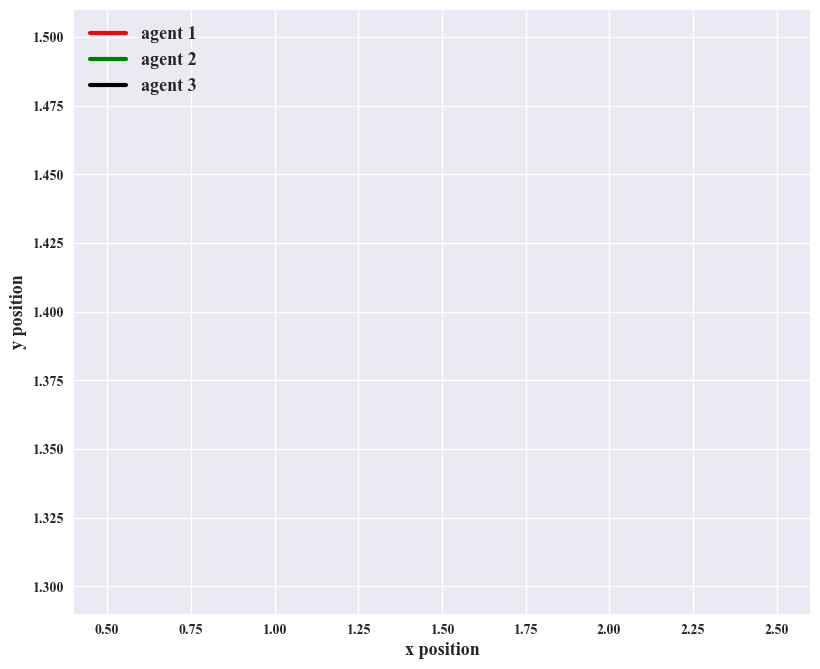

In [92]:
plt.figure(figsize=(9.5,8),dpi=100)
#ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj_opt[:,0], x_trj_opt[:,1], '-r',linewidth=3,label='agent 1')
plt.plot(x_trj_opt[:,4], x_trj_opt[:,5], '-g', linewidth=3,label='agent 2')
plt.plot(x_trj_opt[:,8],x_trj_opt[:,9], '-k', linewidth=3,label='agent 3')
#plt.text(-3, 4.2, "Initial positions:$(0.5,3.5);(-3.5,3.5);(4.5,4.5)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=13)
#plt.arrow(x_trj[:,0][-1], x_trj[:,1][-1],-0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='r')

#plt.arrow(x_trj[:,4][-1], x_trj[:,5][-1],0.15,0.,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='g')|

#plt.arrow(x_trj[:,8][-1], x_trj[:,9][-1],-0.15,-0.05,shape='full', lw=2,
   #length_includes_head=True, head_width=.05, color='k')


plt.xlabel('x position',fontsize=13)
plt.ylabel('y position',fontsize=13)
#plt.yticks(ticks=np.arange(1.3,1.8,0.02))
plt.legend(loc='upper left',fontsize=13);

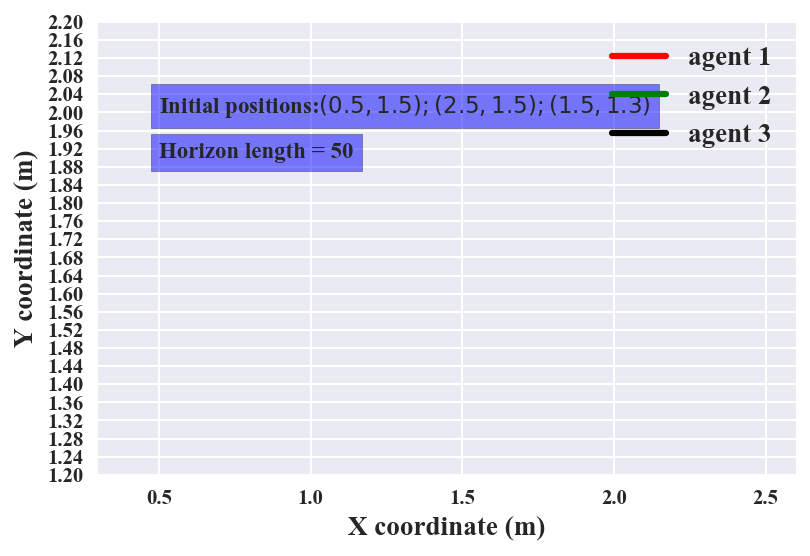

In [76]:
fig = plt.figure(dpi=150)
ax = plt.axes(xlim=(0.3,2.6), ylim=(1.2, 2.2))

ax = plt.gca()

# Plot initial line to fill in as we go
line1, = ax.plot([], [], lw=3,color='r',label='agent 1')
line2, = ax.plot([], [], lw=3,color='g',label='agent 2')
line3, = ax.plot([], [], lw=3,color='k',label='agent 3')
ax.legend(loc='upper right',fontsize=13)
ax.set_xlabel('X coordinate (m)',fontsize=13)
ax.set_ylabel('Y coordinate (m)',fontsize=13)
ax.set_yticks(ticks=np.arange(1.2,2.2,0.04))
ax.text(0.5, 2.0, "Initial positions:$(0.5, 1.5);(2.5, 1.5);(1.5, 1.3)$", bbox=dict(facecolor='blue', alpha=0.5),fontsize=11)
ax.text(0.5,1.9, "Horizon length = 50",bbox=dict(facecolor='blue', alpha=0.5),fontsize=11)
def animate(i):
    # Plot resulting trajecotry of car
    
    
    line1.set_xdata(x_trj_opt[:i,0])
    line2.set_xdata(x_trj_opt[:i,4])
    line3.set_xdata(x_trj_opt[:i,8])

    #line.set_ydata(x_trj[:i,1:10:4])
    line1.set_ydata(x_trj_opt[:i,1])
    line2.set_ydata(x_trj_opt[:i,5])
    line3.set_ydata(x_trj_opt[:i,9])

    
    return line1,line2,line3


anim = FuncAnimation(fig, animate, frames=x_trj_opt.shape[0], interval=200) # animation doesn't show up?


In [77]:
anim

In [44]:
horizon = np.arange(1,N,1)
plt.figure(figsize=(10,8),dpi=100)
sns.scatterplot(x=horizon,y=u_trj[:,0],label='$\omega$ for agent1 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,1],label='acceleration for agent1[m/s]');

sns.scatterplot(x=horizon,y=u_trj[:,2],label='$\omega$ for agent2 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,3],label='acceleration for agent2[m/s]');

sns.scatterplot(x=horizon,y=u_trj[:,4],label='$\omega$ for agent3 [rad/s]');
sns.scatterplot(x=horizon,y=u_trj[:,5],label='acceleration for agent3[m/s]');

plt.legend(fontsize=13);
plt.xlabel('Horizon [$N$]');

KeyboardInterrupt: 

ValueError: Image size of 851x319080 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x800 with 1 Axes>

In [ ]:
anim.save('videos/June8_3AgentsSim_N=50.mp4',fps=10)

### Convergence Anlysis:

In [ ]:
plt.figure(dpi=100)
plt.plot(alpha_trace)
plt.xlabel('# Iteration')
plt.ylabel('Learning rate for line search')


In [ ]:
plt.subplots(figsize=(10,6))
# Plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel('# Iteration')
plt.ylabel('Total cost')
plt.title('Cost trace')

plt.subplot(2, 2, 2)
delta_opt = (np.array(cost_trace) - cost_trace[-1])
plt.plot(delta_opt)
plt.yscale('log')
plt.xlabel('# Iteration')
plt.ylabel('Optimality gap')
plt.title('Convergence plot')

plt.subplot(2, 2, 3)
plt.plot(redu_ratio_trace)
plt.title('Ratio of actual reduction and expected reduction')
plt.ylabel('Reduction ratio')
plt.xlabel('# Iteration')

plt.subplot(2, 2, 4)
plt.plot(regu_trace)
plt.title('Regularization trace')
plt.ylabel('Regularization')
plt.xlabel('# Iteration')
plt.tight_layout()